# EEG Recordings in pediatric patients with an epilepsy diagnosis based on the 10-20 system
https://openneuro.org/datasets/ds003555/versions/1.0.1

## Librerías

In [20]:
import mne
import numpy as np
import pandas as pd
from scipy.signal import coherence, hilbert
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy.io
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from matplotlib import colormaps
from networkx.algorithms.community import greedy_modularity_communities, modularity
import os
from scipy import stats

## Funciones

In [4]:
# creamos una función para leer los archivos
def leer_archivos_de_folder(carpeta_path):
    eeg_files_path = []
    for root, dirs, files in os.walk(carpeta_path):
        for file in files:
            if file.endswith(".edf"):
                eeg_files_path.append(os.path.join(root, file))
    return eeg_files_path

In [5]:
#16 mujeres
lista_paths_mujeres= leer_archivos_de_folder(r'C:\Users\jumma\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\proyecto final\task-hfo-eeg\task-hfo-eeg-mujeres')
#14 hombres
lista_paths_hombres= leer_archivos_de_folder(r'C:\Users\jumma\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\proyecto final\task-hfo-eeg\task-hfo-eeg-hombres')

In [39]:
ch_names= ['Fp1','A2','Fp2','F7','F3','Fz','F4','F8',
 'T3','C3','Cz','C4','T4','T5','P3','Pz',
 'P4','T6','O1','A1','O2','T1','T2']
n_channels= len(ch_names)

In [46]:
eeg_coords = pd.DataFrame({
    'canal': ['Fp1','A2','Fp2','F7','F3','Fz','F4','F8',
              'T3','C3','Cz','C4','T4','T5','P3','Pz',
              'P4','T6','O1','A1','O2','T1','T2'],

    'x': [-0.30,  0.85,  0.30, -0.80, -0.30,  0.00,  0.30,  0.80,
          -0.95, -0.55,  0.00,  0.55,  0.95, -0.85, -0.40,  0.00,
           0.40,  0.85, -0.30, -0.85,  0.30, -0.70,  0.70],

    'y': [ 0.85,  0.00,  0.85,  0.40,  0.60,  0.75,  0.60,  0.40,
           0.00,  0.20,  0.00,  0.20,  0.00, -0.25, -0.10, -0.30,
          -0.10, -0.25, -0.55,  0.00, -0.55, -0.60, -0.60],

    'z': [ 0.40,  0.10,  0.40,  0.20,  0.55,  0.95,  0.55,  0.20,
           0.00,  0.10,  1.00,  0.10,  0.00,  0.10,  0.45,  0.80,
           0.45,  0.10,  0.35,  0.10,  0.35, -0.05, -0.05]
})

eeg_coords.set_index('canal', inplace=True)

In [7]:
# creamos una función para procesar archivos
def cargayprocesamiento(eeg_file_path, fmin=4, fmax=7, duracion_seg=90):
    raw = mne.io.read_raw_edf(eeg_file_path, preload=False)
    raw.crop(tmin=0, tmax=duracion_seg)
    raw.load_data()
    raw.apply_function(lambda x: x.astype('float64'), picks=None)
    raw.filter(1., 45., fir_design='firwin')
    return raw.get_data()

In [8]:
eeg_files_procesados_mujeres = []
for path in lista_paths_mujeres:
    eeg_files_procesados_mujeres.append(cargayprocesamiento(path, fmin=4, fmax=7, duracion_seg=60))

Extracting EDF parameters from C:\Users\jumma\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\proyecto final\task-hfo-eeg\task-hfo-eeg-mujeres\sub-01_ses-01_task-hfo_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 61440  =      0.000 ...    60.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3381 samples (3.302 s)

Extracting EDF parameters from C:\Users\jumma\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\pr

In [9]:
eeg_files_procesados_hombres = []
for path in lista_paths_hombres:
    eeg_files_procesados_hombres.append(cargayprocesamiento(path, fmin=4, fmax=7, duracion_seg=60))

Extracting EDF parameters from C:\Users\jumma\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\proyecto final\task-hfo-eeg\task-hfo-eeg-hombres\sub-03_ses-01_task-hfo_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 61440  =      0.000 ...    60.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3381 samples (3.302 s)

Extracting EDF parameters from C:\Users\jumma\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\pr

ValueError: second must be in 0..59, not 60

In [10]:
#Creamos una función para obtener las matrices de adyacencia
def phase_locking_value(data, ch_names):
    n_channels = len(ch_names)
    analytic_signal = hilbert(data)
    phase_data = np.angle(analytic_signal)
    plv_matrix = np.zeros((n_channels, n_channels))
    for i in range(n_channels):
        for j in range(n_channels):
            phase_diff = phase_data[i] - phase_data[j]
            plv_matrix[i, j] = np.abs(
                np.sum(np.exp(1j * phase_diff)) / phase_diff.size)
    plv_df = pd.DataFrame(plv_matrix, index=ch_names, columns=ch_names)
    np.fill_diagonal(plv_df.values, 0)
    return plv_df

In [11]:
#Creamos una funcion para hacer un stack de los df
def stacks(lista_dfs_, th, porcentaje_):
    stack = np.stack([df.values for df in lista_dfs_])
    above = stack > th
    N = len(lista_dfs_) # = 109
    count_above = above.sum(axis=0)
    min_requerido = int(np.ceil(porcentaje_*N)) 
    result_bool = count_above >= min_requerido
    result_df = pd.DataFrame(result_bool, 
                             index=lista_dfs_[0].index, 
                             columns=lista_dfs_[0].columns).astype(int)
    return result_df

In [12]:
#Definir una función para crear un dataframe con los estadísticos: th25, th50, th75, mu, var, mu_sigma
def df_estadisticos(ensayos_dfs):
    th25, th50, th75, promedio, varianza, mu_sigma = [], [], [], [], [], []
    for sujeto in ensayos_dfs:
        data = sujeto.stack().values
        th25.append(np.percentile(data, 25))
        th50.append(np.percentile(data, 50))
        th75.append(np.percentile(data, 75))
        promedio.append(np.mean(data))
        varianza.append(np.var(data))
        mu_sigma.append(np.mean(data) + np.var(data))
    columnas = np.array([th25, th50, th75, promedio, varianza, mu_sigma]).T
    estadisticos_df = pd.DataFrame(
        index=['min', 'max', 'mediana', 'median_abs_deviation'],
        columns=['th25', 'th50', 'th75', 'promedio', 'varianza', 'mu_sigma']
    )
    estadisticos_df.loc['min'] = columnas.min(axis=0)
    estadisticos_df.loc['max'] = columnas.max(axis=0)
    estadisticos_df.loc['mediana'] = np.median(columnas, axis=0)
    estadisticos_df.loc['median_abs_deviation'] = stats.median_abs_deviation(columnas, axis=0)
    return estadisticos_df

In [31]:
#Crear una función para obtener las métricas del grafo
def metricas_grafo(G):
    clust_coeff = nx.average_clustering(G)

    if nx.is_connected(G):
        path_length = nx.average_shortest_path_length(G)
    else:
        G_big = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
        path_length = nx.average_shortest_path_length(G_big)

    G_rand = nx.gnm_random_graph(n=G.number_of_nodes(), m=G.number_of_edges())

    if not nx.is_connected(G_rand):
        G_rand = max((G_rand.subgraph(c) for c in nx.connected_components(G_rand)), key=len)

    clust_rand = nx.average_clustering(G_rand)
    path_rand = nx.average_shortest_path_length(G_rand)

    small_world_sigma = (clust_coeff / clust_rand) / (path_length / path_rand)

    from networkx.algorithms import community
    communities = community.greedy_modularity_communities(G)
    modularity = community.modularity(G, communities)

    degree_dict = dict(G.degree())
    betwenness = nx.betweenness_centrality(G)
    betwenness = sorted(betwenness.items(), key=lambda x: x[1], reverse=True)

    global_eff = nx.global_efficiency(G)
    local_eff = nx.local_efficiency(G)

    return (clust_coeff, path_length, small_world_sigma, communities, 
            modularity, betwenness, global_eff, local_eff, degree_dict)

In [14]:
# Grafo 2D
def grafo2D(df, pos):
    ensayo_grafo = nx.from_pandas_adjacency(df)
    nx.draw_circular(ensayo_grafo, with_labels=True, font_size=7, ax=pos)
    return ensayo_grafo

In [15]:
def grafo3D(coords, Hub, pos):
    x, y, z = coords['x'].values, coords['y'].values, coords['z'].values
    
    nodes_size = [30 if idx != Hub[0] else 200 for idx in coords.index]
    pos.scatter(x, y, z, alpha=0.5, s=nodes_size)
    for idx, (x_, y_, z_) in enumerate(zip(x, y, z)):
        pos.text(x_, y_, z_, coords.index[idx], fontsize=5)
        if coords.index[idx] == Hub[0]:
            pos.text(x_, y_, z_, 'HUB', color='red', fontweight='bold', fontsize=10)

In [16]:
def grafo_comunidades(comunidades, Hub, coords, pos):
    x, y, z = coords['x'].values, coords['y'].values, coords['z'].values
    
    nodes_size = [30 if idx != Hub[0] else 200 for idx in coords.index]
    pos.scatter(x, y, z, alpha=0.5, s=nodes_size)
    for idx, (x_, y_, z_) in enumerate(zip(x, y, z)):
        pos.text(x_, y_, z_, coords.index[idx], fontsize=5)
        if coords.index[idx] == Hub[0]:
            pos.text(x_, y_, z_, 'HUB', color='red', fontweight='bold', fontsize=10)
    
    colores = ['red', 'green', 'blue', 'black', 'orange']
    for n_comunidad, comunidad in enumerate(comunidades):
        for idx in range(len(comunidad)-1):
            n1, n2 = list(comunidad)[idx], list(comunidad)[idx+1]
            x_ = [coords.loc[n1, 'x'], coords.loc[n2, 'x']]
            y_ = [coords.loc[n1, 'y'], coords.loc[n2, 'y']]
            z_ = [coords.loc[n1, 'z'], coords.loc[n2, 'z']]
            pos.plot(x_, y_, z_, linewidth=3, alpha=0.4, color=colores[n_comunidad])

## Análisis para grupo mujeres

In [17]:
#Creamos una lista de las matrices de adyacencia para el grupo de mujeres
dfs_mujeres=[]
for data in eeg_files_procesados_mujeres:
    dfs_mujeres.append(phase_locking_value(data,ch_names))

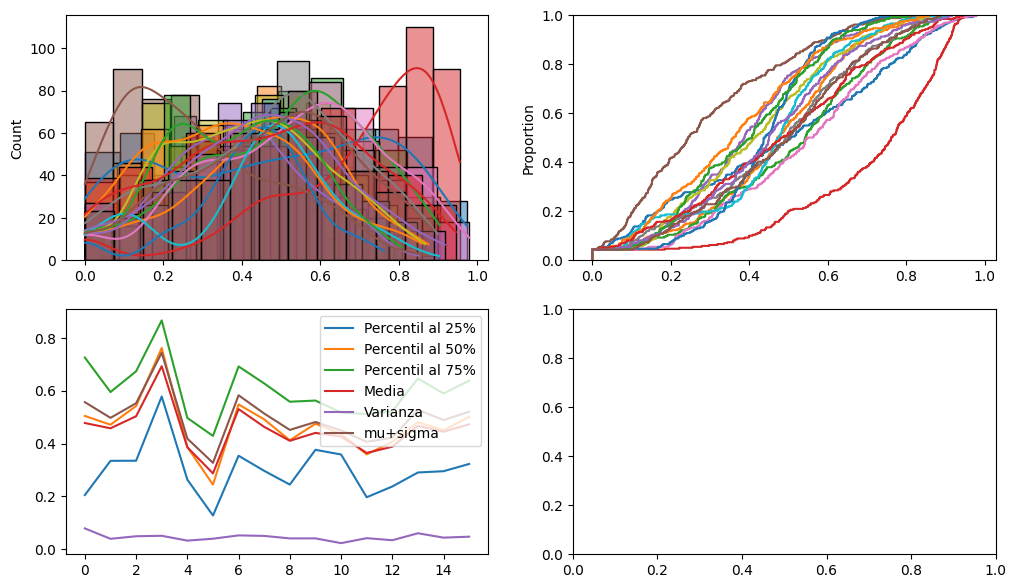

In [18]:
#Análisis para grupo mujeres
ensayos_dfs = dfs_mujeres
th25, th50, th75, promedio, varianza = [], [], [], [], []
mu_sigma = []

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
for sujeto in ensayos_dfs:
# Calculo de estadísticos
    data = sujeto.stack().values
    th25.append(np.percentile(data, 25))
    th50.append(np.percentile(data, 50))
    th75.append(np.percentile(data, 75))
    promedio.append(np.mean(data))
    varianza.append(np.var(data))
    mu_sigma.append(np.mean(data) + np.var(data))
    # Plots
    sns.histplot(sujeto.stack().values, ax=axes[0][0], kde=True)
    sns.ecdfplot(sujeto.stack().values, ax=axes[0][1])
axes[1][0].plot(th25, label='Percentil al 25%')
axes[1][0].plot(th50, label='Percentil al 50%')
axes[1][0].plot(th75, label='Percentil al 75%')
axes[1][0].plot(promedio, label='Media')
axes[1][0].plot(varianza, label='Varianza')
axes[1][0].plot(mu_sigma, label='mu+sigma')
axes[1][0].legend()

In [21]:
 df_estadisticos(dfs_mujeres)

,th25,th50,th75,promedio,varianza,mu_sigma
min,0.127888,0.244607,0.429061,0.287227,0.023178,0.327186
max,0.578238,0.761927,0.866269,0.692978,0.078924,0.743951
mediana,0.296159,0.473383,0.592379,0.451416,0.043024,0.493229
median_abs_deviation,0.054616,0.048502,0.0722,0.033633,0.006891,0.051426


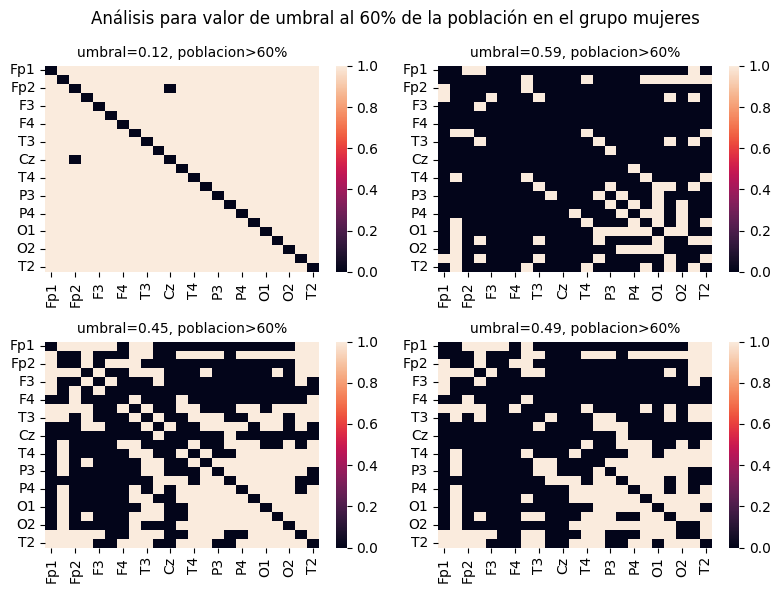

In [24]:
# Análisis para valor de umbral al 60% de la población en el grupo mujeres
resultado_mujeres_df1 = stacks(dfs_mujeres, 0.12, 0.6) # min th25
resultado_mujeres_df2 = stacks(dfs_mujeres, 0.59, 0.6) #mediana th 75
resultado_mujeres_df3 = stacks(dfs_mujeres, 0.45, 0.6) #mediana promedio
resultado_mujeres_df4 = stacks(dfs_mujeres, 0.49, 0.6) #mediana mu_sigma

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

sns.heatmap(resultado_mujeres_df1, ax=axes[0, 0])
sns.heatmap(resultado_mujeres_df2, ax=axes[0, 1])
sns.heatmap(resultado_mujeres_df3, ax=axes[1, 0])
sns.heatmap(resultado_mujeres_df4, ax=axes[1, 1])
axes[0, 0].set_title('umbral=0.12, poblacion>60%', fontsize=10)
axes[0, 1].set_title('umbral=0.59, poblacion>60%', fontsize=10)
axes[1, 0].set_title('umbral=0.45, poblacion>60%', fontsize=10)
axes[1, 1].set_title('umbral=0.49, poblacion>60%', fontsize=10)
fig.suptitle('Análisis para valor de umbral al 60% de la población en el grupo mujeres')
plt.tight_layout()

Text(0.5, 1.0, 'grafo 2D mujeres')

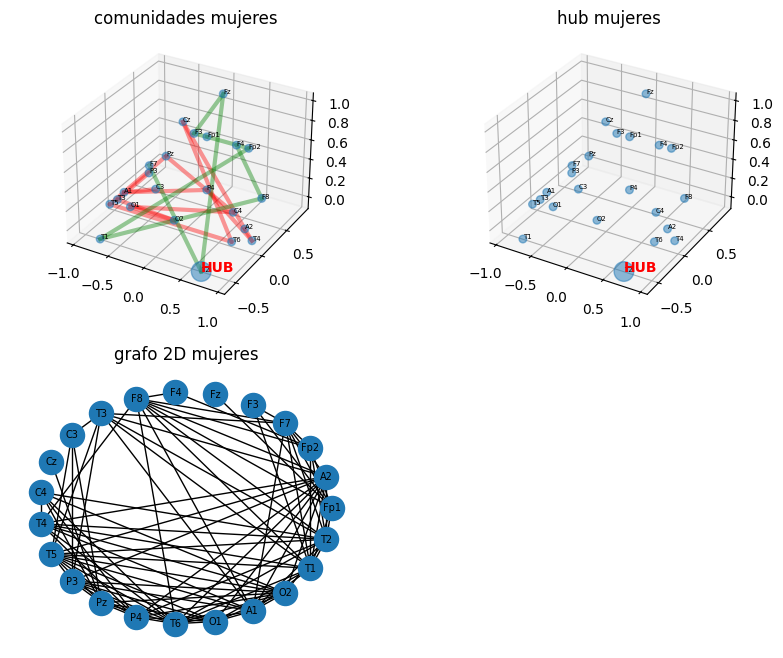

In [47]:
# Convertir de dataframe a grafo
mujeres_grafo_ = nx.from_pandas_adjacency(resultado_mujeres_df4)
# Cálculo de métricas por ensayo
(clust_coeff_m, path_length_m, small_world_sigma_m, communities_m, 
 modularity_m, betwenness_m, global_eff_m, local_eff_m, degree_dict_m) = metricas_grafo(mujeres_grafo_)
# Grafo de resultados para ensayo 3
hub = betwenness_m[0]
fig = plt.figure(figsize=(10, 8))
axes = [fig.add_subplot(2, 2, 1, projection='3d'), 
        fig.add_subplot(2, 2, 2, projection='3d'), 
        fig.add_subplot(2, 2, 3)]
grafo_comunidades(communities_m, hub, eeg_coords, axes[0])
axes[0].set_title('comunidades mujeres')
grafo3D(eeg_coords, hub, axes[1])
axes[1].set_title('hub mujeres')
ensayo_grafo = grafo2D(resultado_mujeres_df4, axes[2])
axes[2].set_title('grafo 2D mujeres')

In [51]:
metricas_grafo(mujeres_grafo_)

(0.6466436944697814,
 1.8695652173913044,
 1.5313921817483647,
 [frozenset({'A1',
             'A2',
             'C3',
             'C4',
             'Cz',
             'O1',
             'O2',
             'P3',
             'P4',
             'Pz',
             'T3',
             'T4',
             'T5',
             'T6'}),
  frozenset({'F3', 'F4', 'F7', 'F8', 'Fp1', 'Fp2', 'Fz', 'T1', 'T2'})],
 0.2082790798611111,
 [('T2', 0.13656241732781899),
  ('T1', 0.12778966949224607),
  ('Pz', 0.10544326183423931),
  ('Fp1', 0.09842144387598933),
  ('F8', 0.08825440931521349),
  ('T6', 0.07207675742178994),
  ('T5', 0.05559670447557161),
  ('A2', 0.040978557876534025),
  ('F7', 0.03634340015064553),
  ('T3', 0.03424745438475415),
  ('A1', 0.03318269029805777),
  ('P3', 0.022617821138579557),
  ('O2', 0.021380962758864034),
  ('Fp2', 0.02052181319098612),
  ('P4', 0.017649549244841824),
  ('O1', 0.017603547293136883),
  ('T4', 0.013073062099036125),
  ('C4', 0.007374992157600854),
  ('C3', 

## Análisis para grupo hombres

In [25]:
#Creamos una lista de las matrices de adyacencia para el grupo 2
dfs_hombres=[]
for data in eeg_files_procesados_hombres:
    dfs_hombres.append(phase_locking_value(data,ch_names))

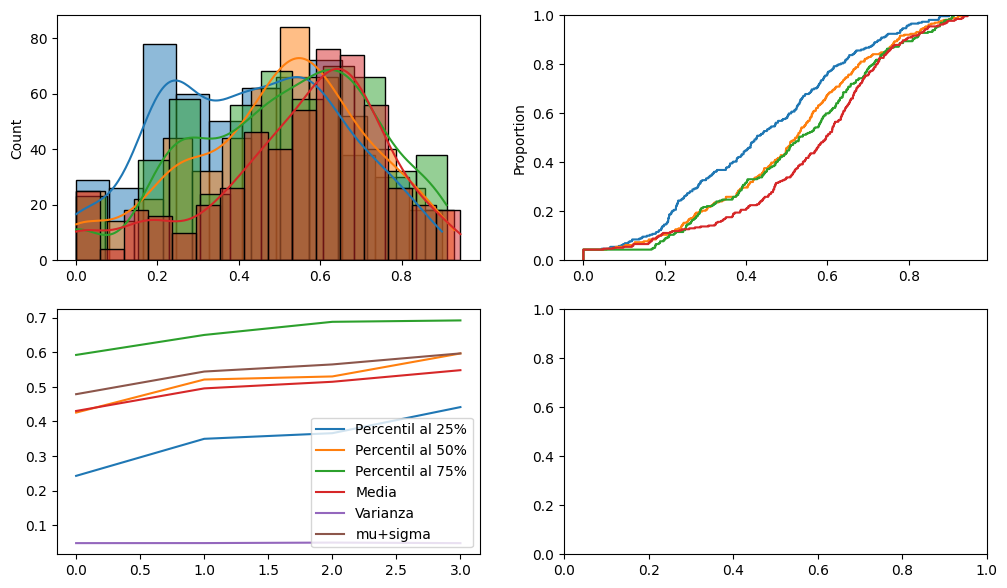

In [26]:
#Análisis para grupo hombres
ensayos_dfs = dfs_hombres
th25, th50, th75, promedio, varianza = [], [], [], [], []
mu_sigma = []

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
for sujeto in ensayos_dfs:
# Calculo de estadísticos
    data = sujeto.stack().values
    th25.append(np.percentile(data, 25))
    th50.append(np.percentile(data, 50))
    th75.append(np.percentile(data, 75))
    promedio.append(np.mean(data))
    varianza.append(np.var(data))
    mu_sigma.append(np.mean(data) + np.var(data))
    # Plots
    sns.histplot(sujeto.stack().values, ax=axes[0][0], kde=True)
    sns.ecdfplot(sujeto.stack().values, ax=axes[0][1])
axes[1][0].plot(th25, label='Percentil al 25%')
axes[1][0].plot(th50, label='Percentil al 50%')
axes[1][0].plot(th75, label='Percentil al 75%')
axes[1][0].plot(promedio, label='Media')
axes[1][0].plot(varianza, label='Varianza')
axes[1][0].plot(mu_sigma, label='mu+sigma')
axes[1][0].legend()

In [27]:
df_estadisticos(dfs_hombres)

,th25,th50,th75,promedio,varianza,mu_sigma
min,0.242814,0.425562,0.592175,0.430204,0.048482,0.478745
max,0.441469,0.596424,0.691846,0.548086,0.050098,0.596568
mediana,0.357962,0.525543,0.668824,0.505047,0.048602,0.554428
median_abs_deviation,0.045814,0.037665,0.020992,0.026298,0.00009,0.026208


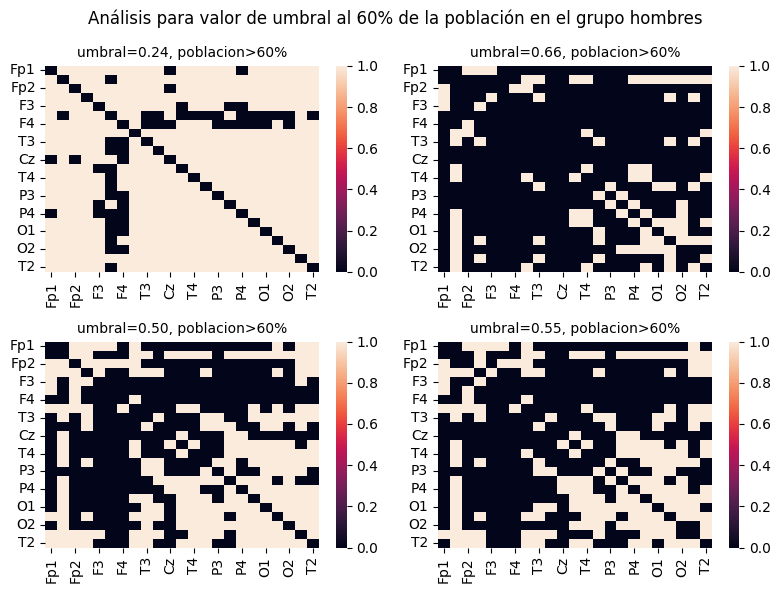

In [28]:
# Análisis para valor de umbral al 60% de la población en el grupo hombres
resultado_hombres_df1 = stacks(dfs_hombres, 0.24, 0.6)
resultado_hombres_df2 = stacks(dfs_hombres, 0.66, 0.6)
resultado_hombres_df3 = stacks(dfs_hombres, 0.50, 0.6)
resultado_hombres_df4 = stacks(dfs_hombres, 0.55, 0.6)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

sns.heatmap(resultado_hombres_df1, ax=axes[0, 0])
sns.heatmap(resultado_hombres_df2, ax=axes[0, 1])
sns.heatmap(resultado_hombres_df3, ax=axes[1, 0])
sns.heatmap(resultado_hombres_df4, ax=axes[1, 1])
axes[0, 0].set_title('umbral=0.24, poblacion>60%', fontsize=10)
axes[0, 1].set_title('umbral=0.66, poblacion>60%', fontsize=10)
axes[1, 0].set_title('umbral=0.50, poblacion>60%', fontsize=10)
axes[1, 1].set_title('umbral=0.55, poblacion>60%', fontsize=10)
fig.suptitle('Análisis para valor de umbral al 60% de la población en el grupo hombres')
plt.tight_layout()

Text(0.5, 1.0, 'grafo 2D hombres')

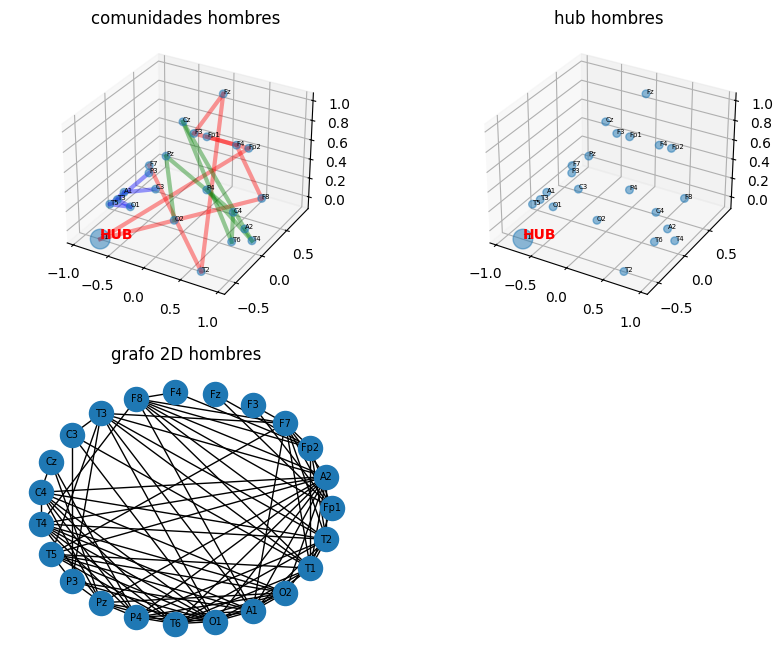

In [48]:
# Convertir de dataframe a grafo
hombres_grafo_ = nx.from_pandas_adjacency(resultado_hombres_df4)
# Cálculo de métricas por ensayo
(clust_coeff_h, path_length_h, small_world_sigma_h, communities_h, 
 modularity_h, betwenness_h, global_eff_h, local_eff_h, degree_dict_h) = metricas_grafo(hombres_grafo_)
# Grafo de resultados para ensayo 3
hub = betwenness_h[0]
fig = plt.figure(figsize=(10, 8))
axes = [fig.add_subplot(2, 2, 1, projection='3d'), 
        fig.add_subplot(2, 2, 2, projection='3d'), 
        fig.add_subplot(2, 2, 3)]
grafo_comunidades(communities_h, hub, eeg_coords, axes[0])
axes[0].set_title('comunidades hombres')
grafo3D(eeg_coords, hub, axes[1])
axes[1].set_title('hub hombres')
ensayo_grafo = grafo2D(resultado_hombres_df4, axes[2])
axes[2].set_title('grafo 2D hombres')

In [52]:
metricas_grafo(hombres_grafo_)

(0.7124723102983973,
 1.8458498023715415,
 1.4685694802390967,
 [frozenset({'F3', 'F4', 'F7', 'F8', 'Fp1', 'Fp2', 'Fz', 'T1', 'T2'}),
  frozenset({'A2', 'C4', 'Cz', 'O2', 'P4', 'Pz', 'T4', 'T6'}),
  frozenset({'A1', 'C3', 'O1', 'P3', 'T3', 'T5'})],
 0.25368923611111116,
 [('T1', 0.1114124990300539),
  ('F7', 0.1047725391657322),
  ('T2', 0.10021147269244),
  ('F8', 0.09157796102489342),
  ('Fp2', 0.08173713508464965),
  ('A2', 0.07882203008714428),
  ('O1', 0.0615158845566369),
  ('A1', 0.060359861647367244),
  ('Fp1', 0.0414450628736343),
  ('P4', 0.03740312945418185),
  ('Pz', 0.029804097314173453),
  ('C4', 0.027969025550754173),
  ('T4', 0.022912472576601558),
  ('T3', 0.022073237008301945),
  ('T5', 0.017622108531199443),
  ('T6', 0.017248223405858874),
  ('P3', 0.009080601937744796),
  ('O2', 0.008266336837765408),
  ('C3', 0.0021732476277930824),
  ('F3', 0.0),
  ('Fz', 0.0),
  ('F4', 0.0),
  ('Cz', 0.0)],
 0.6541501976284585,
 0.8515580232971537,
 {'Fp1': 6,
  'A2': 14,
  'Fp2'

# Comparación

Text(0.5, 1.0, 'Hombres')

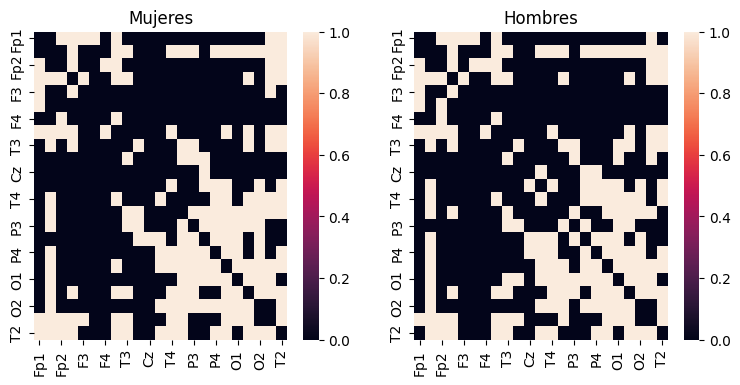

In [53]:
# Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
sns.heatmap(resultado_mujeres_df4, ax=axes[0])
axes[0].set_title("Mujeres")
sns.heatmap(resultado_hombres_df4, ax=axes[1])
axes[1].set_title("Hombres")

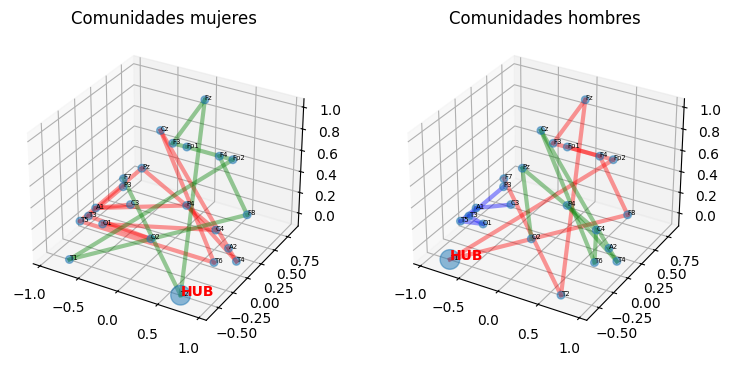

In [54]:
# Comunidades
fig = plt.figure(figsize=(9, 4))
axes = [
    fig.add_subplot(1, 2, 1, projection='3d'),  
    fig.add_subplot(1, 2, 2, projection='3d')  
]

hub_m = betwenness_m[0]
grafo_comunidades(communities_m, hub_m, eeg_coords, axes[0])
axes[0].set_title("Comunidades mujeres")

hub_h = betwenness_h[0]
grafo_comunidades(communities_h, hub_h, eeg_coords, axes[1])
axes[1].set_title("Comunidades hombres")

plt.show()

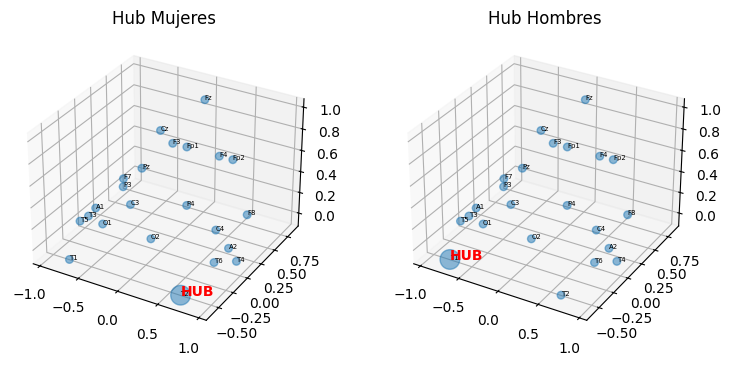

In [55]:
# Hub
fig = plt.figure(figsize=(9, 4))
axes = [
    fig.add_subplot(1, 2, 1, projection='3d'),   
    fig.add_subplot(1, 2, 2, projection='3d')   
]

hub_m = betwenness_m[0]
grafo3D(eeg_coords, hub_m, axes[0])
axes[0].set_title("Hub Mujeres")

hub_h = betwenness_h[0]
grafo3D(eeg_coords, hub_h, axes[1])
axes[1].set_title("Hub Hombres")

plt.show()

Text(0.5, 1.0, 'Grafo 2D - Hombres')

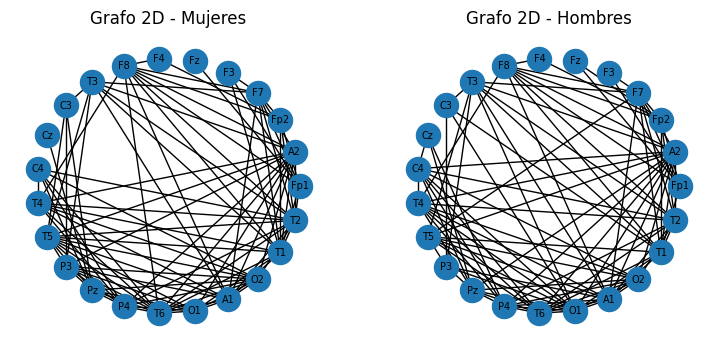

In [56]:
# Grafo 2D
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
ensayo3_grafo = grafo2D(resultado_mujeres_df4, axes[0])
axes[0].set_title('Grafo 2D - Mujeres')
ensayo4_grafo = grafo2D(resultado_hombres_df4, axes[1])
axes[1].set_title('Grafo 2D - Hombres')